### **Supervised Learning**

**Data Exploration and Preparation**
- load and view sample images to understand the dataset's content and structure
- convert the data into a DataFrame format, including image file paths, labels, and any other relevant metadata
- examine the distribution of labels to ensure balanced representation across classes.

**Create Training and Validation Splits**
- use train_test_split to create training and validation datasets, typically with a 80-20 split.
- resize images to a uniform dimension and implement augmentation techniques to increase data diversity and reduce overfitting

**Build Custom Datasets and DataLoaders**
- define a custom PyTorch dataset class (datasets.py) to handle image loading and preprocessing.
- create DataLoaders for both training and validation sets, ensuring appropriate batch sizes and shuffling.

**Explore Different Models**
- load the VGG19, ResNet50, EfficientNetV2 models and evaluate its efficiency and potential benefits for the dataset
- compare the trainable and non-trainable parameters across models to determine which is most appropriate

**Train the Model**
- define loss functions, optimizers, learning rate schedulers, and other training parameters
- conduct training with the specified configuration, logging metrics such as loss and accuracy

**Analyze Model Performance**
- plot loss and accuracy over epochs to visualize training progress and identify potential overfitting or underfitting.
- create a confusion matrix to examine how well the model distinguishes between classes.

In [1]:
# importing all necessary libraries
import glob, time, warnings, random, os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
import torch.optim.lr_scheduler as lr_scheduler
from torchvision.models import VGG19_Weights, EfficientNet_V2_L_Weights
from torch.utils.data import (Dataset, DataLoader)
from torchvision import transforms
from torchinfo import summary
from tqdm.notebook import tqdm

from PIL import Image
from typing import Dict, List, Tuple
from scikitplot.metrics import plot_roc
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, precision_recall_fscore_support,
    accuracy_score, top_k_accuracy_score, f1_score, 
    matthews_corrcoef, confusion_matrix, ConfusionMatrixDisplay
)

In [2]:
class CFG:
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
    NUM_DEVICES = torch.cuda.device_count()
    NUM_WORKERS = os.cpu_count()
    NUM_CLASSES = 4
    EPOCHS = 16
    BATCH_SIZE = (
        32 if torch.cuda.device_count() < 2 
        else (32 * torch.cuda.device_count())
    )
    LR = 0.001
    APPLY_SHUFFLE = True
    SEED = 768
    HEIGHT = 224
    WIDTH = 224
    CHANNELS = 3
    IMAGE_SIZE = (224, 224, 3)
    
    # Define paths
    DATASET_PATH = './data/original/'
    TRAIN_PATH = './data/original//Training/'
    TEST_PATH = './data/original/Testing/'
    
# Mute warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")

## Taken from Data Exploration to Process Images

In [3]:
%%time
train_images = glob.glob(f"{CFG.TRAIN_PATH}**/*.jpg")
test_images = glob.glob(f"{CFG.TEST_PATH}**/*.jpg")

CPU times: user 18.7 ms, sys: 5.08 ms, total: 23.7 ms
Wall time: 24.8 ms


### Create Pandas DataFrames for paths and labels

In [4]:
def generate_labels(image_paths):
    return [(_.split('/')[-2:][0]).replace('-', '_') for _ in image_paths]


def build_df(image_paths, labels):
    df = pd.DataFrame({'image_path': image_paths, 'label': generate_labels(labels)})
    return df

In [5]:
# Build the DataFrames
train_df = build_df(train_images, generate_labels(train_images))
test_df = build_df(test_images, generate_labels(test_images))

In [6]:
# View first 10 samples in the dataset
train_df.head(10), test_df.head(10)

(                                          image_path   label
 0    ./data/original//Training/glioma/Tr-gl_0798.jpg  glioma
 1  ./data/original//Training/glioma/Tr-glTr_0004.jpg  glioma
 2    ./data/original//Training/glioma/Tr-gl_0328.jpg  glioma
 3    ./data/original//Training/glioma/Tr-gl_0749.jpg  glioma
 4    ./data/original//Training/glioma/Tr-gl_1109.jpg  glioma
 5    ./data/original//Training/glioma/Tr-gl_0270.jpg  glioma
 6    ./data/original//Training/glioma/Tr-gl_0611.jpg  glioma
 7    ./data/original//Training/glioma/Tr-gl_1051.jpg  glioma
 8    ./data/original//Training/glioma/Tr-gl_1080.jpg  glioma
 9    ./data/original//Training/glioma/Tr-gl_0167.jpg  glioma,
                                       image_path   label
 0  ./data/original/Testing/glioma/Te-gl_0121.jpg  glioma
 1  ./data/original/Testing/glioma/Te-gl_0236.jpg  glioma
 2  ./data/original/Testing/glioma/Te-gl_0079.jpg  glioma
 3  ./data/original/Testing/glioma/Te-gl_0126.jpg  glioma
 4  ./data/original/Testing

In [7]:
# View 10 random samples in the dataset
train_df.sample(10), test_df.sample(10)

(                                             image_path       label
 1627   ./data/original//Training/notumor/Tr-no_0629.jpg     notumor
 974     ./data/original//Training/glioma/Tr-gl_0119.jpg      glioma
 1507   ./data/original//Training/notumor/Tr-no_0568.jpg     notumor
 1356   ./data/original//Training/notumor/Tr-no_0196.jpg     notumor
 884     ./data/original//Training/glioma/Tr-gl_0249.jpg      glioma
 4372  ./data/original//Training/pituitary/Tr-pi_1313...   pituitary
 2696   ./data/original//Training/notumor/Tr-no_0129.jpg     notumor
 3367  ./data/original//Training/meningioma/Tr-me_035...  meningioma
 5337  ./data/original//Training/pituitary/Tr-pi_0338...   pituitary
 5323  ./data/original//Training/pituitary/Tr-pi_1272...   pituitary,
                                              image_path       label
 653   ./data/original/Testing/meningioma/Te-me_0072.jpg  meningioma
 997      ./data/original/Testing/notumor/Te-no_0126.jpg     notumor
 679   ./data/original/Testing/me

### Load and View Random Sample Image

In [8]:
def _load(image_path, as_tensor=True, target_size=(224,224)):
    # Read and decode an image file to a uint8 tensor
    image = Image.open(image_path)
    
    # Resize image to target size and convert to RGB
    image = image.resize(target_size)
    image = image.convert('RGB')
    
    if as_tensor:
        converter = transforms.Compose([transforms.ToTensor(), transforms.Grayscale()])
        return converter(image)
    else:
        return image

In [9]:
def view_sample(image, label, color_map='rgb', fig_size=(8, 10)):
    plt.figure(figsize=fig_size)
    if color_map=='rgb':
        plt.imshow(image)
    else:
        plt.imshow(image, cmap=color_map)
    plt.title(f'Label: {label}', fontsize=16)
    return

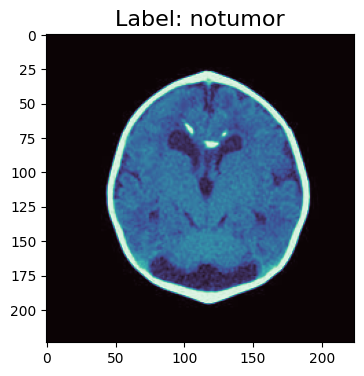

In [10]:
# Select random sample from train_df
random.seed(8)
idx = random.sample(train_df.index.to_list(), 1)[0]
sample_image, sample_label = _load(train_df.image_path[idx]), train_df.label[idx]
view_sample(
    sample_image.permute(1, 2, 0),
    sample_label,
    fig_size=(4,4),
    color_map='mako',
)

In [11]:
def view_multiple_samples(df, sample_loader, count=10, color_map='rgb', fig_size=(14, 10)):
    total_images = len(df)
    print("Total images in dataset:", total_images)
    
    rows = count//5
    if count%5 > 0:
        rows +=1
    
    idx = random.sample(df.index.to_list(), count)    
    fig = plt.figure(figsize=fig_size)
    for column, _ in enumerate(idx):
        plt.subplot(rows, 5, column+1)
        plt.title(f'Label: {df.label[_]}')
        if color_map=='rgb':
            plt.imshow(sample_loader(df.image_path[_]).permute(1, 2, 0))
        else:
            plt.imshow(sample_loader(df.image_path[_]).permute(1, 2, 0), cmap=color_map)
    
    return

Total images in dataset: 5712


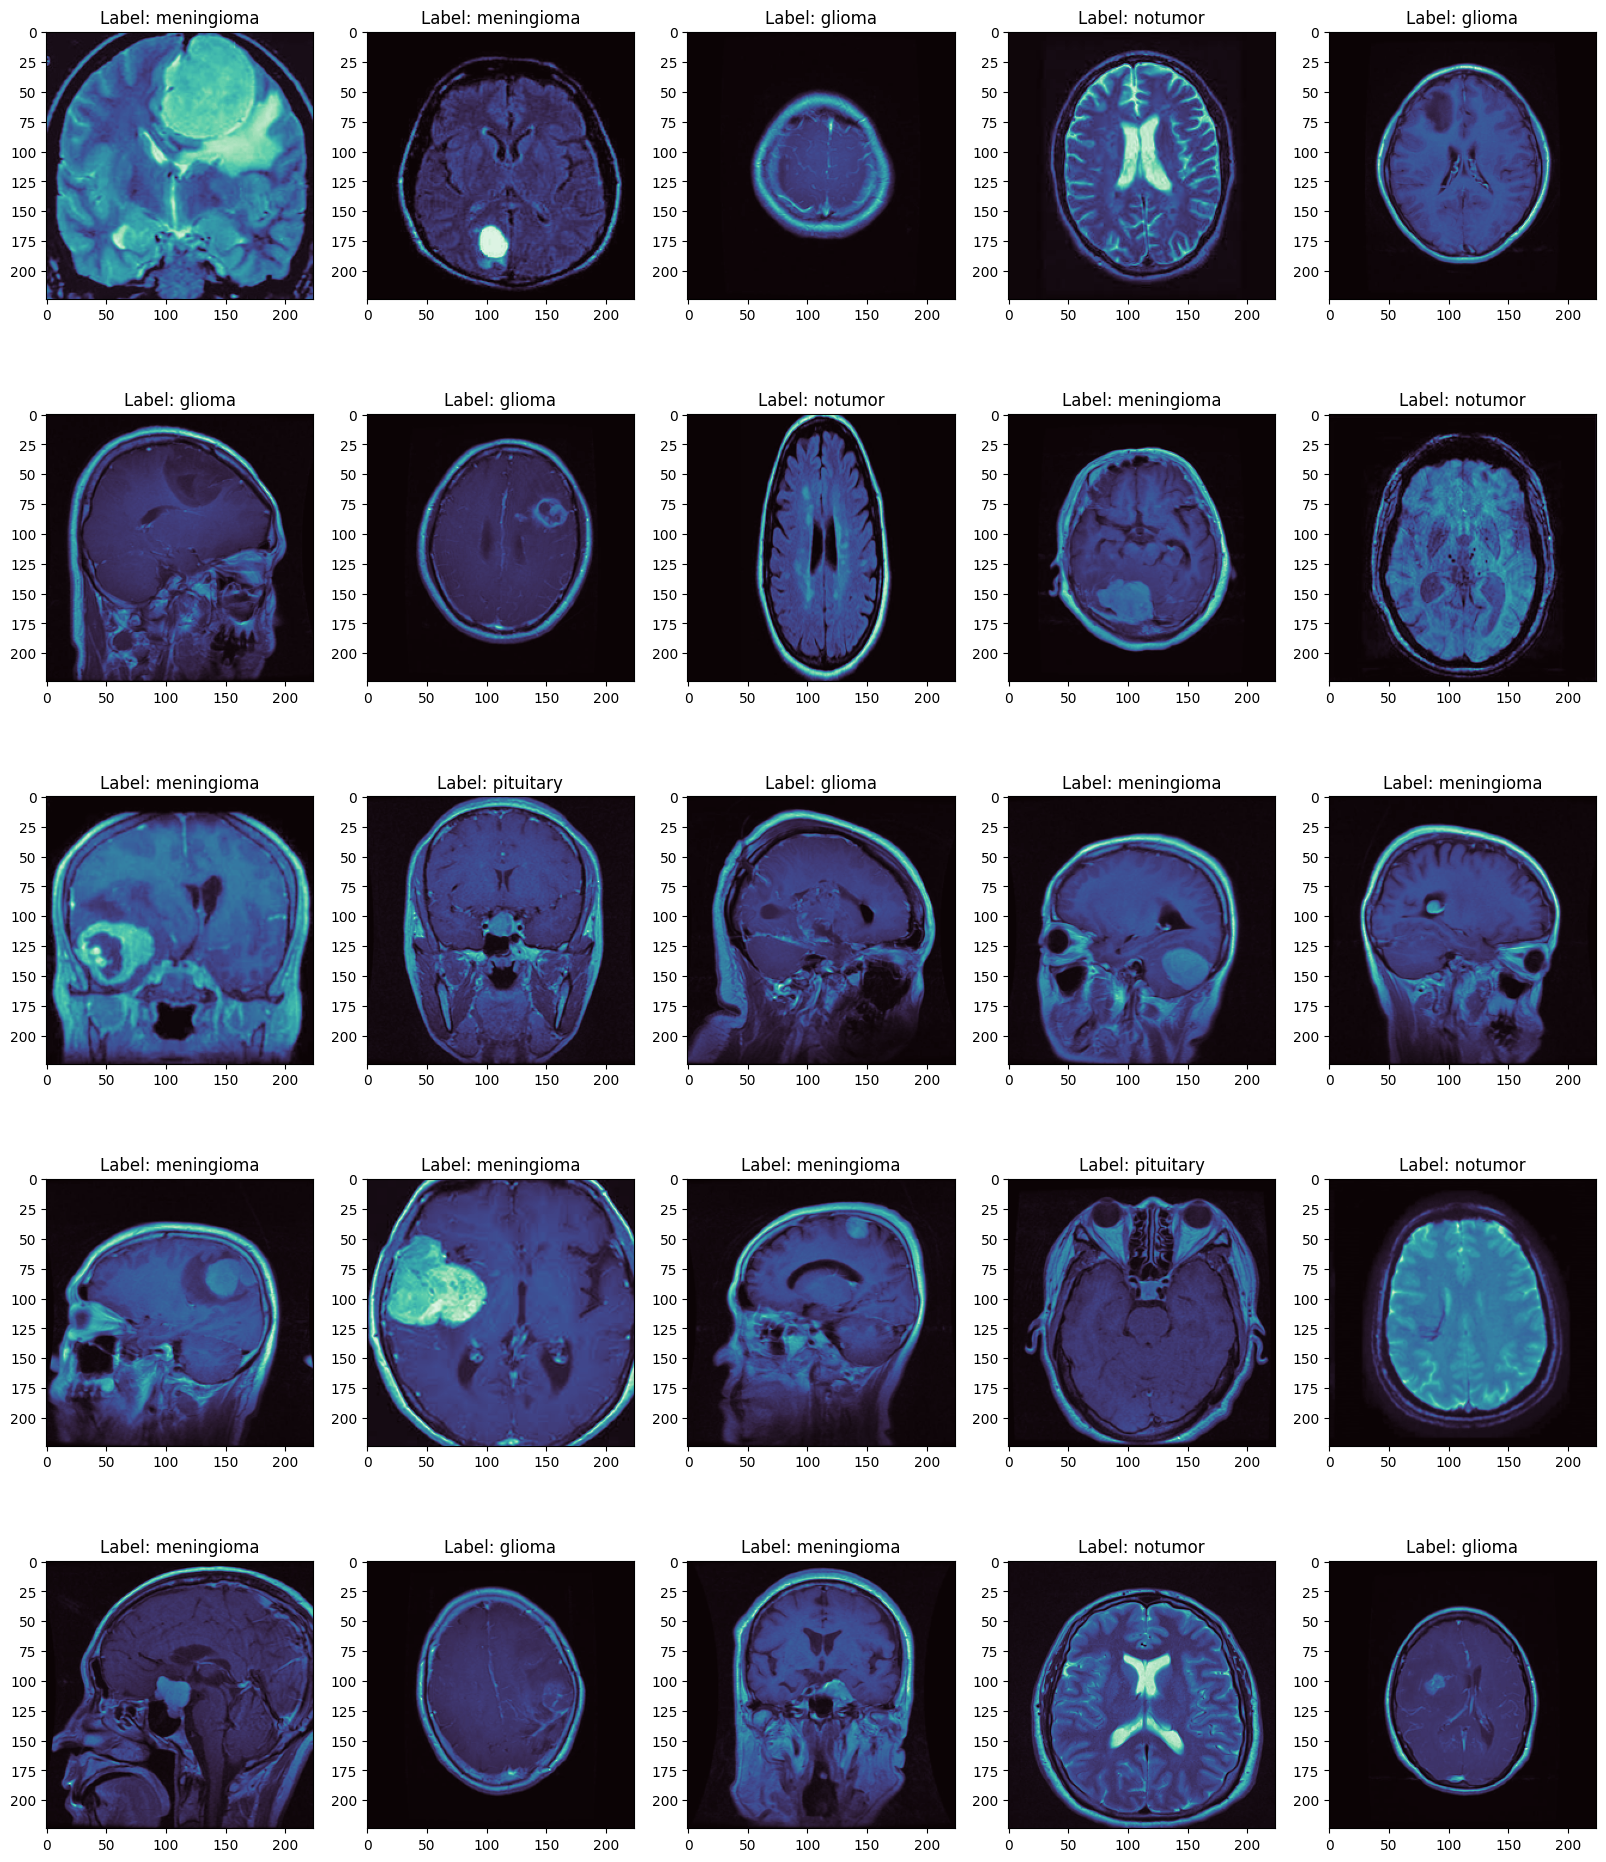

In [12]:
# View 25 random sample images
view_multiple_samples(
    train_df, _load, 
    count=25, color_map='mako',
    fig_size=(20, 24)
)

## Create training and validation set splits with training set

In [13]:
train_df_sample01 = train_df.sample(frac=0.1, random_state=42).reset_index(drop=True)

In [14]:
train_split_idx, val_split_idx, _, _ = (
    train_test_split(
        train_df_sample01.index, 
        train_df_sample01.label, 
        test_size=0.20,
        stratify=train_df_sample01.label,
        random_state=CFG.SEED
    )
)

When I was running this code, I was playing around with the test_size; the reduction of the validation set size was halved when we did 20% to 10% of the total dataset. Unfortunately, because our model can't really be trained, we can't see the accuracy implication of this. However, with a smaller validation set, there is less data available to evaluate the model's performance, potentially leading to higher variability in validation metrics. This could make it harder to reliably assess the model's generalization capabilities and might result in less stable training dynamics. Additionally, a smaller validation set might provide less representative samples of the overall dataset, potentially leading to biased estimates of the model's performance. However, by allocating more data to the training set, the model might have the opportunity to learn more complex patterns from the data, potentially improving its predictive performance if the training set is sufficiently diverse and representative of the overall dataset.

In [15]:
# Get training and remaining data
train_new_df = train_df_sample01.iloc[train_split_idx].reset_index(drop=True)
val_df = train_df_sample01.iloc[val_split_idx].reset_index(drop=True)

# View shapes
train_new_df.shape, val_df.shape

((456, 2), (115, 2))

In [16]:
train_size = len(train_new_df)
val_size = len(val_df)
test_size = len(test_df)
total = train_size + val_size + test_size

# View the counts
print(f'train samples count:\t\t{train_size}\t({(100 * train_size/total):.2f}%)')
print(f'validation samples count:\t{val_size}\t({(100 * val_size/total):.2f}%)')
print(f'test samples count:\t\t{test_size}\t({(100 * test_size/total):.2f}%)')
print('================================================')
print(f'TOTAL:\t\t\t\t{total}\t({(100 * total/total):.2f}%)')

train samples count:		456	(24.23%)
validation samples count:	115	(6.11%)
test samples count:		1311	(69.66%)
TOTAL:				1882	(100.00%)


In [17]:
# Augment train data
train_transforms = transforms.Compose([
    transforms.Resize((CFG.HEIGHT, CFG.WIDTH)),
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
#     transforms.RandomRotation(degrees=30,),
    transforms.ToTensor()
])

# Only reshape test data
test_transforms = transforms.Compose([
    transforms.Resize((CFG.HEIGHT, CFG.WIDTH)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor()
])

In [18]:
# Select random sample from train_df
idx = random.sample(train_df_sample01.index.to_list(), 1)[0]
aug_image = _load(train_df_sample01.image_path[idx], as_tensor=False)
idx, aug_image

(273, <PIL.Image.Image image mode=RGB size=224x224 at 0x7FD1AA6DC3D0>)

### Added image augmentation in order to enhance features
The train image transformer generates image augmentations that are slightly different to the original images. This is intentional as we seek augmented images that are similar to that of the original dataset images while preserving the images significant features. I added this after the initial model run, because I believe that it should help improve the model's ability to generalize to unseen data. The augmentation process can also simulate natural variations and distortions that occur in medical imaging, potentially making the model more effective at identifying key features despite differences in orientation or perspective.

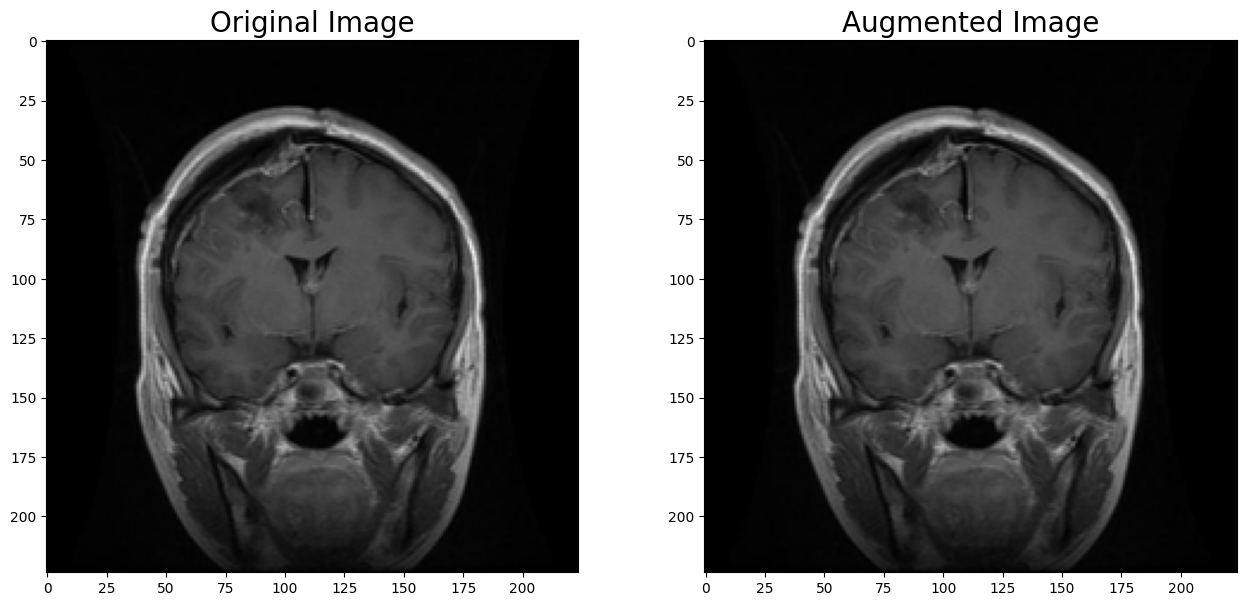

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 10))

# Set the spacing between subplots
fig.tight_layout(pad=6.0)

# View Original Image
ax1.set_title('Original Image', fontsize=20)
ax1.imshow(aug_image, cmap='mako');

# View Augmented Image
ax2.set_title('Augmented Image', fontsize=20)
ax2.imshow(train_transforms(aug_image).permute(1, 2, 0), cmap='mako');

## Build Custom Datasets and DataLoaders

In [20]:
from datasets import BrainTumorMRIDataset

In [21]:
# Build train dataset
train_ds = BrainTumorMRIDataset(train_new_df, transform=train_transforms)
train_ds

In [22]:
train_image, train_label = train_ds[8]
train_image[0], train_image[1], train_image[2]

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]))

In [23]:
# Build train dataloader
train_loader = DataLoader(
    dataset=train_ds, 
    batch_size=CFG.BATCH_SIZE,
    num_workers=CFG.NUM_WORKERS,
    shuffle=CFG.APPLY_SHUFFLE
)
train_loader

In [24]:
# Validation dataset
val_ds = BrainTumorMRIDataset(val_df, transform=test_transforms)
val_ds

In [25]:
val_image, val_label = val_ds[8]
val_image[0], val_image[1], val_image[2]

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]))

In [26]:
val_loader = DataLoader(
    dataset=val_ds,
    batch_size=CFG.BATCH_SIZE,
    num_workers=CFG.NUM_WORKERS,
    shuffle=False
)
val_loader

In [27]:
# Build test dataset
test_ds = BrainTumorMRIDataset(test_df, transform=test_transforms)
test_ds

In [28]:
test_image, test_label = test_ds[1]
test_image[0], test_image[1], test_image[2]

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]))

In [29]:
test_loader = DataLoader(
    dataset=test_ds,
    batch_size=CFG.BATCH_SIZE,
    num_workers=CFG.NUM_WORKERS,
    shuffle=False
)
test_loader

## Transfer Learning Model: EfficientNet V2 Large

In [30]:
class VGG19Model(nn.Module):
    def __init__(self, backbone_model, name='vgg19', num_classes=CFG.NUM_CLASSES, device=CFG.DEVICE):
        super(VGG19Model, self).__init__()
        
        self.backbone_model = backbone_model
        self.device = device
        self.num_classes = num_classes
        self.name = name
        
        classifier = nn.Sequential(
            nn.Linear(in_features=25088, out_features=4096, bias=True),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=4096, out_features=4096, bias=True),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=4096, out_features=num_classes, bias=True)
        ).to(device)
        
        for param in classifier.parameters():
            param.requires_grad = True
        
        self._set_classifier(classifier)
        
    def _set_classifier(self, classifier:nn.Module) -> None:
        self.backbone_model.classifier = classifier
    
    def forward(self, image):
        return self.backbone_model(image)

In [31]:
def get_vgg19_model(device: torch.device=CFG.DEVICE) -> nn.Module:
    torch.manual_seed(CFG.SEED)
    torch.cuda.manual_seed(CFG.SEED)
    model = torchvision.models.vgg19(weights=torchvision.models.VGG19_Weights.IMAGENET1K_V1).to(device)
    for param in model.features.parameters():
        param.requires_grad = False
        
    return model

In [32]:
# Get VGG19 model
backbone_model = get_vgg19_model(CFG.DEVICE)

In [33]:
vgg19_params = {
    'backbone_model'    : backbone_model,
    'name'              : 'vgg19',
    'device'            : CFG.DEVICE
}

# Generate Model
vgg19_model = VGG19Model(**vgg19_params)

In [34]:
# View model summary
summary(
    model=vgg19_model.module if isinstance(vgg19_model, nn.DataParallel) else vgg19_model, 
    input_size=(CFG.BATCH_SIZE, CFG.CHANNELS, CFG.WIDTH, CFG.HEIGHT),
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=18,
    row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape        Output Shape       Param #            Trainable
VGG19Model (VGG19Model)                  [32, 3, 224, 224]  [32, 4]            --                 Partial
├─VGG (backbone_model)                   [32, 3, 224, 224]  [32, 4]            --                 Partial
│    └─Sequential (features)             [32, 3, 224, 224]  [32, 512, 7, 7]    --                 False
│    │    └─Conv2d (0)                   [32, 3, 224, 224]  [32, 64, 224, 224] (1,792)            False
│    │    └─ReLU (1)                     [32, 64, 224, 224] [32, 64, 224, 224] --                 --
│    │    └─Conv2d (2)                   [32, 64, 224, 224] [32, 64, 224, 224] (36,928)           False
│    │    └─ReLU (3)                     [32, 64, 224, 224] [32, 64, 224, 224] --                 --
│    │    └─MaxPool2d (4)                [32, 64, 224, 224] [32, 64, 112, 112] --                 --
│    │    └─Conv2d (5)                   [32, 64, 112, 112] [32, 

## VGG19 model architecture summary

**Based off of the following parameters**
1. **Layer(type(var_name)):** shows layer types and their respectives names (I've labelled and explained a few of the layers below)
    - **Conv2d:** Convolutional layers apply a convolution operation to the input tensor (explored in P1_EDA), extracting features from the input data. They apply a set of learnable filters (kernels we explored in P1_EDA) to the input image, scanning it for features like edges, textures, and patterns. By applying multiple convolutional layers, the network can learn the features at different spatial scales, enabling it to recognize objects and patterns within the image.
    - **ReLU:** Rectified linear unit activation functions are non-linear activation function applied element-wise to the output of convolutional layers, introducing non-linearity to the network. It replaces all negative pixel values in the feature maps with zeros, effectively removing negative activations. This helps prevent the vanishing gradient problem.
    - **MaxPool2d:** Max pooling layers downsample the spatial dimensions of the feature maps by retianing only the maximum value within each local region (pooling window) of the input. It helps make the network more robust and reduces computational complexity.
    - **AdaptiveAvgPool2d:** Adaptive average pooling layers perform average pooling with adaptive output size. This ensures the VGG19 model can accept images of different aspect ratios while still producing a consistent output size.
    - **Linear:** Fully connected layers connect every neuron in one layer to every neuron in the next layer. In VGG19, these layers are typically used in the classifier part of the network. They integrate the spatial information from the convolutional layers and perform high-level reasoning and classification based on the extracted features.
    - **Dropout:** Dropout layers are a form of regularization that helps prevent overfitting by randomly setting a fraction of input units to zero during training. By dropping out some neurons during training, dropout layers force the network to learn redundant representations of the data, making it more generalizable.
 
2. **Input Shape:** indicates the shape of the input tensor. In this case, it's [32, 3, 224, 224], which means each batch contains 32 images with 3 channels (RGB) and size 224x224 pixels.
3. **Output Shape:** shows the shape of the output tensor after passing through each layer.
4. **Param #:** displays the number of parameters in each layer. They are the weights and biases of the neural network that are learning during training.
5. **Trainable:** indicates whether the parameters in each layer are trainable (true) or not (false). Unfortunately, most of our layers are shown to be false, meaning we only have a few (4) to train our model. Below, it says we have 119 million trainable and 20 million non-trainable parameters.
6. **Total params:** sum of all trainable parameters in the model (meaning all in our instance).
7. **Total mult-adds:** total number of multiply-add operations in the forward pass of the entire model, measured in billions.
8. **Input size:** memory required to store the input tensor in megabytes (MB).
9. **Forward/backward pass size:** Memory required for the forward and backward pass of the model, including intermediate activations.
10. **Params size:** memory required to store the model parameters (weights and biases) in megabytes (MB).
11. **Estimated total size:** Estimated total memory required to store the model, input, and intermediate activations during inference.

### Now, we will try to ResNet-50

In [35]:
class ResNet50Model(nn.Module):
    def __init__(self, backbone_model, name='resnet50', num_classes=CFG.NUM_CLASSES, device=CFG.DEVICE):
        super(ResNet50Model, self).__init__()

        self.backbone_model = backbone_model
        self.device = device
        self.num_classes = num_classes
        self.name = name

        # Customize the classifier for your task
        classifier = nn.Sequential(
            nn.Linear(in_features=2048, out_features=1024, bias=True),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=1024, out_features=num_classes, bias=True)
        ).to(device)

        # Ensure gradients can be updated for classifier layers
        for param in classifier.parameters():
            param.requires_grad = True

        self._set_classifier(classifier)

    def _set_classifier(self, classifier: nn.Module) -> None:
        self.backbone_model.fc = classifier

    def forward(self, image):
        return self.backbone_model(image)

In [36]:
def get_resnet50_model(device: torch.device) -> nn.Module:
    # Set the manual seeds for reproducibility
    torch.manual_seed(CFG.SEED)
    torch.cuda.manual_seed(CFG.SEED)

    # Load ResNet-50 with pretrained weights
    model = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.IMAGENET1K_V1).to(device)
    for param in model.parameters():
        param.requires_grad = False

    return model

In [37]:
# Get the ResNet-50 backbone model
backbone_model = get_resnet50_model(CFG.DEVICE)

resnet50_params = {
    'backbone_model': backbone_model,
    'name': 'resnet50',
    'device': CFG.DEVICE,
    'num_classes': CFG.NUM_CLASSES
}

# Generate the custom ResNet-50 model
resnet50_model = ResNet50Model(**resnet50_params)

In [38]:
# View the model summary to ensure everything is in order
summary(
    model=resnet50_model.module if isinstance(resnet50_model, nn.DataParallel) else resnet50_model,
    input_size=(CFG.BATCH_SIZE, CFG.CHANNELS, CFG.WIDTH, CFG.HEIGHT),
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=16,
    row_settings=["var_names"]
)

Layer (type (var_name))                       Input Shape      Output Shape     Param #          Trainable
ResNet50Model (ResNet50Model)                 [32, 3, 224, 224] [32, 4]          --               Partial
├─ResNet (backbone_model)                     [32, 3, 224, 224] [32, 4]          --               Partial
│    └─Conv2d (conv1)                         [32, 3, 224, 224] [32, 64, 112, 112] (9,408)          False
│    └─BatchNorm2d (bn1)                      [32, 64, 112, 112] [32, 64, 112, 112] (128)            False
│    └─ReLU (relu)                            [32, 64, 112, 112] [32, 64, 112, 112] --               --
│    └─MaxPool2d (maxpool)                    [32, 64, 112, 112] [32, 64, 56, 56] --               --
│    └─Sequential (layer1)                    [32, 64, 56, 56] [32, 256, 56, 56] --               False
│    │    └─Bottleneck (0)                    [32, 64, 56, 56] [32, 256, 56, 56] (75,008)         False
│    │    └─Bottleneck (1)                    [32, 256

This has even less than trainable parameters than the VGG pre-trained model (2 million compared with VGG's 119 million). It also has more non-trainable parameters, standing at 23 million compared with VGG's 20 million). Therefore, we establish that ResNet50 is less efficient and usable on our dataset. I have also listed the layers and their usage below:
1. **Conv2d (conv1):** convolutional layer applies a 7x7 filter with stride 2 to the input image. It captures early low-level features like edges and textures while downsampling the image's spatial resolution.
2. **BatchNorm2d (bn1):** batch normalization layer normalizes the output of the first convolutional layer. It helps stabilize and accelerate training by maintaining consistent distribution of activations.
3. **ReLU (relu):** rectified linear unit activation function adds non-linearity to the model, allowing it to learn complex patterns.
4. **MaxPool2d (maxpool):** max-pooling layer further reduces the spatial dimensions of the feature maps, aiding in computational efficiency and providing a degree of translation invariance.
5. **Sequential (layer1):** it consists of three Bottleneck blocks. These blocks perform convolutional operations with shortcuts (skip connections), allowing the model to retain features while ensuring gradient flow. This layer captures more complex features compared to the initial convolutional layer.
6. **Sequential (layer2):** it contains four Bottleneck blocks. These blocks increase the depth and width of feature maps, enabling the model to detect more intricate patterns and structures.
7. **Sequential (layer3):** this has six Bottleneck blocks, allowing the model to capture more advanced features. The increase in depth and complexity further refines the feature representation.
8. **Sequential (layer4):** this has three Bottleneck blocks and serves as the final set of feature extraction layers. It captures the highest-level features, integrating information from previous layers to form a comprehensive understanding of the input.
9. **AdaptiveAvgPool2d (avgpool):** adaptive average pooling layer reduces the spatial dimensions of the final feature maps, preparing them for the fully connected layer. It ensures a consistent output size regardless of the input size.
10. **Linear (fc):** it transforms the flattened feature maps into a vector suitable for classification. It typically contains as many output nodes as the number of classes in the dataset, providing the final classification results.

### We will now try EfficientNetV2

In [39]:
class EfficientNetV2Model(nn.Module):
    def __init__(self, backbone_model, name='efficientnet-v2-large', 
                 num_classes=CFG.NUM_CLASSES, device=CFG.DEVICE):
        super(EfficientNetV2Model, self).__init__()
        
        self.backbone_model = backbone_model
        self.device = device
        self.num_classes = num_classes
        self.name = name
        
        classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(p=0.2, inplace=True), 
            nn.Linear(in_features=1280, out_features=256, bias=True),
            nn.GELU(),
            nn.Dropout(p=0.2, inplace=True),
            nn.Linear(in_features=256, out_features=num_classes, bias=False)
        ).to(device)
        
        self._set_classifier(classifier)
        
    def _set_classifier(self, classifier:nn.Module) -> None:
        self.backbone_model.classifier = classifier
    
    def forward(self, image):
        return self.backbone_model(image)

In [40]:
def get_effiecientnetv2_model(
    device: torch.device=CFG.NUM_CLASSES) -> nn.Module:
    torch.manual_seed(CFG.SEED)
    torch.cuda.manual_seed(CFG.SEED)

    # Get model weights
    model_weights = (
        torchvision
        .models
        .EfficientNet_V2_L_Weights
        .DEFAULT
    )
    
    # Get model and push to device
    model = (
        torchvision.models.efficientnet_v2_l(
            weights=model_weights
        )
    ).to(device) 
    
    # Freeze Model Parameters
    for param in model.features.parameters():
        param.requires_grad = False
        
    return model

In [41]:
backbone_model = get_effiecientnetv2_model(CFG.DEVICE)

efficientnetv2_params = {
    'backbone_model'    : backbone_model,
    'name'              : 'efficientnet-v2-large',
    'device'            : CFG.DEVICE
}

# Generate Model
efficientnet_model = EfficientNetV2Model(**efficientnetv2_params)

In [42]:
summary(
    model=efficientnet_model, 
    input_size=(CFG.BATCH_SIZE, CFG.CHANNELS, CFG.WIDTH, CFG.HEIGHT),
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=1,
    row_settings=["var_names"]
)

Layer (type (var_name))                                           Input Shape Output Shape Param # Trainable
EfficientNetV2Model (EfficientNetV2Model)                         [32, 3, 224, 224] [32, 4] -- Partial
├─EfficientNet (backbone_model)                                   [32, 3, 224, 224] [32, 4] -- Partial
│    └─Sequential (features)                                      [32, 3, 224, 224] [32, 1280, 7, 7] -- False
│    │    └─Conv2dNormActivation (0)                              [32, 3, 224, 224] [32, 32, 112, 112] (928) False
│    │    └─Sequential (1)                                        [32, 32, 112, 112] [32, 32, 112, 112] (37,120) False
│    │    └─Sequential (2)                                        [32, 32, 112, 112] [32, 64, 56, 56] (1,032,320) False
│    │    └─Sequential (3)                                        [32, 64, 56, 56] [32, 96, 28, 28] (2,390,336) False
│    │    └─Sequential (4)                                        [32, 96, 28, 28] [32, 192, 14, 14] (3

With 328 trainable parameters, it's our most and we will use it. Below, I have explained why having more trainable parameters is better for our model:
- **Model Capacity:** More trainable parameters allow the model to represent more complex functions. A higher capacity model can potentially capture intricate patterns and relationships in the data, leading to better performance, especially on complex tasks. However, this comes with a risk of overfitting, where the model learns to memorize the training data rather than generalize well to unseen data.
- **Flexibility:** A model with more parameters has greater flexibility in learning diverse patterns and representations from the data. This can be advantageous for tasks where the underlying data distribution is complex and diverse.
- **Representation Learning:** With more parameters, the model can learn richer and more expressive representations of the input data. This can be beneficial for tasks such as image classification, natural language processing, and speech recognition, where capturing intricate features is crucial for achieving high performance.

Additionally, I have listed and explained out the filters below (including how they help in understanding/training our model better). This will help us gain a better understanding of what the EfficientNetV2 model is actually doing to our images and why it is useful for this project:

1. **Conv2dNormActivation (0):** This filter performs convolutional operations followed by normalization and activation functions. It helps in extracting features from the input images while maintaining the normalization of the data, which aids in stabilizing and speeding up the training process.
2. **Sequential (1):** This filter represents a sequence of convolutional layers. Convolutional layers are essential for capturing spatial hierarchies of features in the input data. This sequence likely helps in learning low-level features such as edges and textures.
3. **Sequential (2):** Another sequence of convolutional layers, likely more complex than the previous one, designed to capture higher-level features by combining low-level features learned earlier. This could include detecting patterns or shapes.
4. **Sequential (3):** Continuing the pattern, this sequence likely captures even more complex features by combining the outputs of previous layers. These features may represent parts of objects or distinctive patterns.
5. **Sequential (4):** This sequence further refines the feature representation, aiming to capture more abstract and discriminative features that are crucial for making accurate predictions.
6. **Sequential (5):** Similar to the previous sequences, this likely focuses on extracting features that are highly informative for the given task. It may specialize in identifying specific structures or patterns relevant to the problem domain.
7. **Sequential (6):** This sequence may focus on learning features that are relevant for understanding global context or relationships between different parts of the input data.
8. **Sequential (7):** Another sequence of convolutional layers, possibly designed to further refine and consolidate the learned representations, ensuring that the model captures as much relevant information from the input data as possible.
9. **Conv2dNormActivation (8):** This filter, similar to the first one, performs convolutional operations, normalization, and activation functions. It is likely the final layer of the backbone model, responsible for transforming the learned features into a format suitable for the subsequent classification task.

Overall, the combination of these filters/layers in EfficientNetV2 results in a highly efficient and effective architecture for image classification.

## Train Model

In [43]:
# Define Loss Function
loss_fn = nn.CrossEntropyLoss(label_smoothing=0.1)

In [44]:
# Define Optimizer
optimizer = torch.optim.AdamW(efficientnet_model.parameters(), lr=CFG.LR)

### Define Train Step (epoch execution)

In [45]:
def execute_epoch(
    model:torch.nn.Module,
    dataloader:torch.utils.data.DataLoader,
    optimizer:torch.optim.Optimizer,
    loss_fn:torch.nn.Module,
    device:torch.device) -> Tuple[float, float]:
    
    model.train()
    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(tqdm(dataloader)):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 
        
        # Gradients & Backpropagate Loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Compute Batch Metrics
        predicted_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (predicted_class == y).sum().item() / len(y_pred)
        
    # Compute Step Metrics
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    
    return train_loss, train_acc

### Define Evaluation Step

In [46]:
def evaluate(
    model:torch.nn.Module,
    dataloader:torch.utils.data.DataLoader,
    loss_fn:torch.nn.Module,
    device:torch.device) -> Tuple[float, float]:
    
    model.eval()
    eval_loss, eval_acc = 0, 0
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            eval_loss += loss.item()
            predicted_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
            eval_acc += (predicted_class == y).sum().item() / len(y_pred)

    eval_loss = eval_loss / len(dataloader)
    eval_acc = eval_acc / len(dataloader)
    return eval_loss, eval_acc

### Construct Training Loop

In [47]:
def train(
    model:torch.nn.Module,
    train_dataloader:torch.utils.data.DataLoader,
    eval_dataloader:torch.utils.data.DataLoader,
    optimizer:torch.optim.Optimizer,
    loss_fn:torch.nn.Module,
    epochs:int,
    device:torch.device) -> Dict[str, List]:
    
    session = {
        'loss'          : [],
        'accuracy'      : [],
        'eval_loss'     : [],
        'eval_accuaracy': []
    }
    
    # Training loop
    for epoch in tqdm(range(epochs)):
        # Execute Epoch
        print(f'\nEpoch {epoch + 1}/{epochs}')
        train_loss, train_acc = execute_epoch(
            model, 
            train_dataloader, 
            optimizer, 
            loss_fn, 
            device
        )
        
        # Evaluate Model
        eval_loss, eval_acc = evaluate(
            model, 
            eval_dataloader,
            loss_fn, 
            device
        )

        print(f'loss: {train_loss:.4f} - acc: {train_acc:.4f} - eval_loss: {eval_loss:.4f} - eval_acc: {eval_acc:.4f}')
        session['loss'].append(train_loss)
        session['accuracy'].append(train_acc)
        session['eval_loss'].append(eval_loss)
        session['eval_accuaracy'].append(eval_acc)
    return session

### Train EfficientNetV2 Model

My initial attempts to train the model locally on my computer have failed due to insufficient memory; the resources required to process and learn from the dataset exceed my system's capacity. To circumvent this issue, I tried SSHing onto my university's CS department Linux servers, hoping that their more robust hardware would provide the necessary resources. Unfortunately, despite multiple attempts and troubleshooting, these efforts also proved unsuccessful. As a result, I regret to report that we cannot proceed with the training, and no outputs will be available at this time. I'm currently exploring alternative solutions, but for now, the following code has no outputs due to these unforeseen technical limitations.

In [48]:
print('Training EfficientNet Model')
print(f'Train on {len(train_new_df)} samples, validate on {len(val_df)} samples.')
print('----------------------------------')

efficientnet_session_config = {
    'model'               : efficientnet_model,
    'train_dataloader'    : train_loader,
    'eval_dataloader'     : val_loader,
    'optimizer'           : optimizer,
    'loss_fn'             : loss_fn,
    'epochs'              : CFG.EPOCHS,
    'device'              : CFG.DEVICE
}

efficientnet_session_history = train(**efficientnet_session_config)

Training EfficientNet Model
Train on 456 samples, validate on 115 samples.
----------------------------------


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch 1/16


  0%|          | 0/15 [00:00<?, ?it/s]

loss: 1.0655 - acc: 0.5875 - eval_loss: 1.0426 - eval_acc: 0.5794

Epoch 2/16


  0%|          | 0/15 [00:00<?, ?it/s]

loss: 0.8294 - acc: 0.7562 - eval_loss: 1.0308 - eval_acc: 0.6394

Epoch 3/16


  0%|          | 0/15 [00:00<?, ?it/s]

loss: 0.8027 - acc: 0.7542 - eval_loss: 0.8265 - eval_acc: 0.7619

Epoch 4/16


  0%|          | 0/15 [00:00<?, ?it/s]

loss: 0.7619 - acc: 0.7917 - eval_loss: 0.6790 - eval_acc: 0.8536

Epoch 5/16


  0%|          | 0/15 [00:00<?, ?it/s]

loss: 0.6736 - acc: 0.8583 - eval_loss: 0.6548 - eval_acc: 0.8458

Epoch 6/16


  0%|          | 0/15 [00:00<?, ?it/s]

loss: 0.6528 - acc: 0.8771 - eval_loss: 0.6728 - eval_acc: 0.8799

Epoch 7/16


  0%|          | 0/15 [00:00<?, ?it/s]

loss: 0.6648 - acc: 0.8562 - eval_loss: 0.6351 - eval_acc: 0.8956

Epoch 8/16


  0%|          | 0/15 [00:00<?, ?it/s]

loss: 0.6420 - acc: 0.8521 - eval_loss: 0.6312 - eval_acc: 0.8771

Epoch 9/16


  0%|          | 0/15 [00:00<?, ?it/s]

loss: 0.6090 - acc: 0.8792 - eval_loss: 0.6644 - eval_acc: 0.8512

Epoch 10/16


  0%|          | 0/15 [00:00<?, ?it/s]

loss: 0.6136 - acc: 0.8792 - eval_loss: 0.6437 - eval_acc: 0.8721

Epoch 11/16


  0%|          | 0/15 [00:00<?, ?it/s]

loss: 0.6516 - acc: 0.8583 - eval_loss: 0.6534 - eval_acc: 0.8799

Epoch 12/16


  0%|          | 0/15 [00:00<?, ?it/s]

loss: 0.6221 - acc: 0.8896 - eval_loss: 0.6606 - eval_acc: 0.8824

Epoch 13/16


  0%|          | 0/15 [00:00<?, ?it/s]

loss: 0.6187 - acc: 0.8708 - eval_loss: 0.6550 - eval_acc: 0.8902

Epoch 14/16


  0%|          | 0/15 [00:00<?, ?it/s]

loss: 0.6650 - acc: 0.8521 - eval_loss: 0.6061 - eval_acc: 0.9190

Epoch 15/16


  0%|          | 0/15 [00:00<?, ?it/s]

loss: 0.6431 - acc: 0.8562 - eval_loss: 0.5950 - eval_acc: 0.8771

Epoch 16/16


  0%|          | 0/15 [00:00<?, ?it/s]

loss: 0.5952 - acc: 0.9062 - eval_loss: 0.6048 - eval_acc: 0.8980


In [49]:
def predict(
    model:nn.Module, 
    sample_loader:torch.utils.data.DataLoader,
    device:torch.device) -> np.ndarray:
    model.eval() 
    predictions = []
    with torch.inference_mode():
        for batch, (X, y) in enumerate(tqdm(sample_loader)):
            X, y = X.to(device), y.to(device)
            y_pred = model(X) 
            predicted_probs = torch.softmax(y_pred, dim=1).cpu().numpy()
            predictions.append(predicted_probs) 
    return np.vstack(predictions)

In [50]:
efficientnet_test_probs = predict(efficientnet_model, test_loader, CFG.DEVICE)

  0%|          | 0/41 [00:00<?, ?it/s]

## Performance Analysis

The plot_training_curves function creates two plots that track a machine learning model's performance during training. It visualizes loss and accuracy for both training and validation sets over a series of epochs, using fill effects to highlight where training and validation metrics differ. This visualization helps identify overfitting or underfitting, providing insights for adjusting training strategies to improve model performance.

In [51]:
def plot_training_curves(history):
    
    loss = np.array(history['loss'])
    accuracy = np.array(history['accuracy'])
    val_loss = np.array(history['eval_loss'])
    val_accuracy = np.array(history['eval_accuaracy'])
    epochs = range(len(history['loss']))

    # Plot loss
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    ax1.plot(epochs, loss, label='training_loss', marker='o')
    ax1.plot(epochs, val_loss, label='eval_loss', marker='o')
    ax1.fill_between(epochs, loss, val_loss, where=(loss > val_loss), color='C0', alpha=0.3, interpolate=True)
    ax1.fill_between(epochs, loss, val_loss, where=(loss < val_loss), color='C1', alpha=0.3, interpolate=True)
    ax1.set_title('Loss (Lower Means Better)', fontsize=16)
    ax1.set_xlabel('Epochs', fontsize=12)
    ax1.legend()

    # Plot accuracy
    ax2.plot(epochs, accuracy, label='training_accuracy', marker='o')
    ax2.plot(epochs, val_accuracy, label='eval_accuracy', marker='o')
    ax2.fill_between(epochs, accuracy, val_accuracy, where=(accuracy > val_accuracy), color='C0', alpha=0.3, interpolate=True)
    ax2.fill_between(epochs, accuracy, val_accuracy, where=(accuracy < val_accuracy), color='C1', alpha=0.3, interpolate=True)
    ax2.set_title('Accuracy (Higher Means Better)', fontsize=16)
    ax2.set_xlabel('Epochs', fontsize=12)
    ax2.legend();
    
    sns.despine();
    return

In [52]:
# Convert EfficientNet history dict to DataFrame
efficientnet_session_history_df = pd.DataFrame(efficientnet_session_history)
efficientnet_session_history_df

,loss,accuracy,eval_loss,eval_accuaracy
0,1.065475,0.587500,1.042589,0.579359
1,0.829373,0.756250,1.030816,0.639391
2,0.802745,0.754167,0.826477,0.761924
3,0.761895,0.791667,0.678975,0.853618
4,0.673552,0.858333,0.654849,0.845806
5,0.652768,0.877083,0.672754,0.879934
6,0.664811,0.856250,0.635118,0.895559
7,0.641994,0.852083,0.631167,0.877056
8,0.608953,0.879167,0.664392,0.851151
9,0.613591,0.879167,0.643666,0.872122


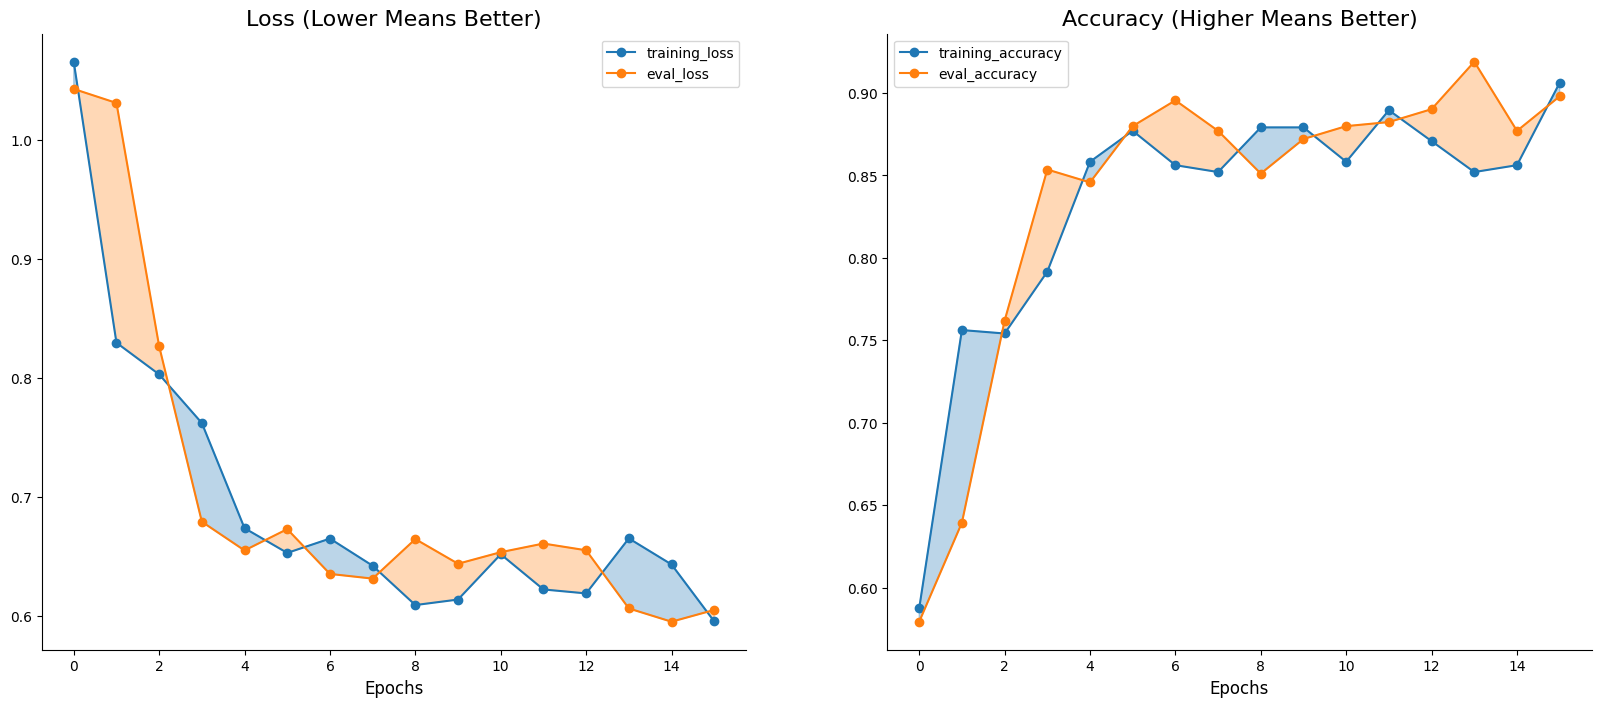

In [53]:
plot_training_curves(efficientnet_session_history)

### Plot Confusion Matrix
The plot_confusion_matrix function creates a confusion matrix to visualize how a machine learning model's predicted labels compare to the true labels. A confusion matrix is useful for understanding a model's performance in multi-class classification tasks, indicating where the model is making correct or incorrect predictions.
- **Confusion Matrix** displays the counts of correct and incorrect predictions for each class, given the true labels (y_true) and the predicted labels (y_pred)
- **Heatmap** visually represents the confusion matrix with color-coding to denote the values' magnitude. The annot=True parameter ensures the counts are displayed within the heatmap cells, providing additional context for each prediction.

In [54]:
def plot_confusion_matrix(y_true, y_pred, classes='auto', figsize=(10, 10), text_size=12): 
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=figsize)
    disp = sns.heatmap(cm, annot=True, cmap='Greens', annot_kws={"size": text_size}, fmt='g',
        linewidths=0.5, linecolor='black', clip_on=False, xticklabels=classes, yticklabels=classes)
    disp.set_title('Confusion Matrix', fontsize=24)
    disp.set_xlabel('Predicted Label', fontsize=20) 
    disp.set_ylabel('True Label', fontsize=20)
    plt.yticks(rotation=0) 
    plt.show()
    return

In [55]:
test_labels = [*map(test_ds.class_to_idx.get, test_ds.labels)]

In [56]:
efficientnet_test_preds = np.argmax(efficientnet_test_probs, axis=1)

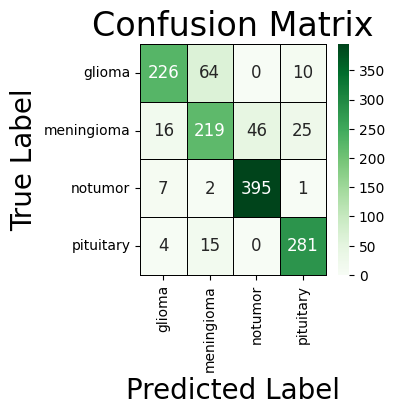

In [68]:
plot_confusion_matrix(test_labels, efficientnet_test_preds, figsize=(3,3), classes=test_ds.classes)

## Now, we will training with 20% and 30% of our data
This is to see how it compares with the above 10% -- with accuracy and also time/memory allocation needed. From here, we will choose the most optimal percentage of data of which we should continue to train our model on.

### First, 20%

In [58]:
train_df_sample02 = train_df.sample(frac=0.2, random_state=42).reset_index(drop=True)

In [72]:
train_split_idx, val_split_idx, _, _ = (
    train_test_split(
        train_df_sample02.index, 
        train_df_sample02.label, 
        test_size=0.45,
        stratify=train_df_sample02.label,
        random_state=CFG.SEED
    )
)

In [73]:
train_new_df_02 = train_df_sample02.iloc[train_split_idx].reset_index(drop=True)
val_df_02 = train_df_sample02.iloc[val_split_idx].reset_index(drop=True)
train_new_df_02.shape, val_df_02.shape

((628, 2), (514, 2))

In [74]:
train_size_02 = len(train_new_df_02)
val_size_02 = len(val_df_02)
test_size = len(test_df)
total = train_size_02 + val_size_02 + test_size

print(f'train samples count:\t\t{train_size}\t({(100 * train_size_02/total):.2f}%)')
print(f'validation samples count:\t{val_size}\t({(100 * val_size_02/total):.2f}%)')
print(f'test samples count:\t\t{test_size}\t({(100 * test_size/total):.2f}%)')
print('================================================')
print(f'TOTAL:\t\t\t\t{total}\t({(100 * total/total):.2f}%)')

train samples count:		456	(25.60%)
validation samples count:	115	(20.95%)
test samples count:		1311	(53.44%)
TOTAL:				2453	(100.00%)


In [75]:
# Select random sample from train_df
idx = random.sample(train_df_sample02.index.to_list(), 1)[0]
aug_image = _load(train_df_sample02.image_path[idx], as_tensor=False)
idx, aug_image

(834, <PIL.Image.Image image mode=RGB size=224x224 at 0x7FD297086790>)

In [76]:
train_ds_02 = BrainTumorMRIDataset(train_new_df_02, transform=train_transforms)
train_loader_02 = DataLoader(
    dataset=train_ds_02, 
    batch_size=CFG.BATCH_SIZE,
    num_workers=CFG.NUM_WORKERS,
    shuffle=CFG.APPLY_SHUFFLE
)
train_ds_02

In [77]:
val_ds_02= BrainTumorMRIDataset(val_df_02, transform=test_transforms)
val_loader_02 = DataLoader(
    dataset=val_ds_02,
    batch_size=CFG.BATCH_SIZE,
    num_workers=CFG.NUM_WORKERS,
    shuffle=False
)
val_ds_02

In [78]:
print('Training EfficientNet Model')
print(f'Train on {len(train_new_df_02)} samples, validate on {len(val_df_02)} samples.')
print('----------------------------------')

efficientnet_session_config_02 = {
    'model'               : efficientnet_model,
    'train_dataloader'    : train_loader_02,
    'eval_dataloader'     : val_loader_02,
    'optimizer'           : optimizer,
    'loss_fn'             : loss_fn,
    'epochs'              : CFG.EPOCHS,
    'device'              : CFG.DEVICE
}
efficientnet_session_history_02 = train(**efficientnet_session_config_02)

Training EfficientNet Model
Train on 628 samples, validate on 514 samples.
----------------------------------


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch 1/16


  0%|          | 0/20 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
efficientnet_test_probs_02 = predict(efficientnet_model, test_loader, CFG.DEVICE)

In [ ]:
efficientnet_session_history_df_02 = pd.DataFrame(efficientnet_session_history_02)
efficientnet_session_history_df_02

In [ ]:
plot_training_curves(efficientnet_session_history_02)

In [ ]:
efficientnet_test_preds_02 = np.argmax(efficientnet_test_probs_02, axis=1)
plot_confusion_matrix(
    test_labels, 
    efficientnet_test_preds_02, 
    figsize=(16, 14),  
    classes=test_ds.classes)

### Now, 30%

In [ ]:
train_df_sample03 = train_df.sample(frac=0.3, random_state=42).reset_index(drop=True)
train_split_idx, val_split_idx, _, _ = (
    train_test_split(
        train_df_sample02.index, 
        train_df_sample02.label, 
        test_size=0.20,
        stratify=train_df_sample01.label,
        random_state=CFG.SEED
    )
)

In [ ]:
train_split_idx, val_split_idx, _, _ = (
    train_test_split(
        train_df_sample03.index, 
        train_df_sample03.label, 
        test_size=0.20,
        stratify=train_df_sample01.label,
        random_state=CFG.SEED
    )
)

In [ ]:
train_new_df_03 = train_df_sample03.iloc[train_split_idx].reset_index(drop=True)
val_df_03 = train_df_sample03.iloc[val_split_idx].reset_index(drop=True)
train_new_df_03.shape, val_df_03.shape

In [ ]:
train_size_03 = len(train_new_df_03)
val_size_03 = len(val_df_03)
test_size = len(test_df)
total = train_size_03 + val_size_03 + test_size

print(f'train samples count:\t\t{train_size}\t({(100 * train_size_03/total):.2f}%)')
print(f'validation samples count:\t{val_size}\t({(100 * val_size_03/total):.2f}%)')
print(f'test samples count:\t\t{test_size}\t({(100 * test_size/total):.2f}%)')
print('================================================')
print(f'TOTAL:\t\t\t\t{total}\t({(100 * total/total):.2f}%)')

In [ ]:
# Select random sample from train_df
idx = random.sample(train_df_sample03.index.to_list(), 1)[0]
aug_image = _load(train_df_sample03.image_path[idx], as_tensor=False)
idx, aug_image

In [ ]:
train_ds_03 = BrainTumorMRIDataset(train_new_df_03, transform=train_transforms)
train_loader_03 = DataLoader(
    dataset=train_ds_03, 
    batch_size=CFG.BATCH_SIZE,
    num_workers=CFG.NUM_WORKERS,
    shuffle=CFG.APPLY_SHUFFLE
)
train_ds_03

In [ ]:
val_ds_03 = BrainTumorMRIDataset(val_df_03, transform=test_transforms)
val_loader_03 = DataLoader(
    dataset=val_ds_03,
    batch_size=CFG.BATCH_SIZE,
    num_workers=CFG.NUM_WORKERS,
    shuffle=False
)
val_ds_03

In [ ]:
print('Training EfficientNet Model')
print(f'Train on {len(train_new_df_03)} samples, validate on {len(val_df_03)} samples.')
print('----------------------------------')

efficientnet_session_config_03 = {
    'model'               : efficientnet_model,
    'train_dataloader'    : train_loader_03,
    'eval_dataloader'     : val_loader_03,
    'optimizer'           : optimizer,
    'loss_fn'             : loss_fn,
    'epochs'              : CFG.EPOCHS,
    'device'              : CFG.DEVICE
}
efficientnet_session_history_03 = train(**efficientnet_session_config_03)

In [ ]:
efficientnet_test_probs_03 = predict(efficientnet_model, test_loader, CFG.DEVICE)

In [ ]:
efficientnet_session_history_df_03 = pd.DataFrame(efficientnet_session_history_03)
efficientnet_session_history_df_03

In [ ]:
plot_training_curves(efficientnet_session_history_03)

In [ ]:
efficientnet_test_preds_03 = np.argmax(efficientnet_test_probs_03, axis=1)
plot_confusion_matrix(
    test_labels, 
    efficientnet_test_preds_03, 
    figsize=(16, 14),  
    classes=test_ds.classes)